source: https://www.kaggle.com/dromosys/handwriting-recognition-cnn/output

In [15]:
import h5py
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop

from keras.models import load_model

In [16]:
d = {}
from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
# forms = pd.read_csv('../input/iam-handwriting-top50/forms_for_parsing.txt', header=None)
# print(forms.head)
with open('iam-handwriting-top50/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer
print(len(d.keys()))

1539


In [17]:
tmp = []
target_list = []

path_to_files = os.path.join('iam-handwriting-top50/data_subset/data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
#     print(filename)
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

(4899,)
(4899,)


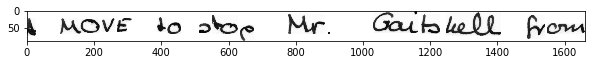

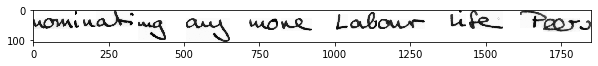

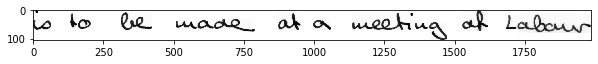

In [18]:
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

In [20]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:5], img_targets[:5], encoded_Y[:5])

['iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-00.png'
 'iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-01.png'
 'iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-02.png'
 'iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-03.png'
 'iam-handwriting-top50/data_subset/data_subset/a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [21]:
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


In [52]:
# # Now create generators for randomly cropping 113x113 patches from these images

batch_size = 8 #16
num_classes = 50

# Start with train generator shared in the class and add image augmentations
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]
                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%

                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)
                    
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train, y_train)

In [23]:
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

In [ ]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize_images(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))
model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# don't run this cell it takes forever
# nb_epoch = 8

# samples_per_epoch = 3268
# nb_val_samples = 842

# # #save every model using Keras checkpoint
# from keras.callbacks import ModelCheckpoint
# #filepath="check-{epoch:02d}-{val_loss:.4f}.hdf5"
# filepath="low_loss.hdf5"
# checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
# callbacks_list = [checkpoint]

# # #Model fit generator
# history_object = model.fit_generator(train_generator, steps_per_epoch = samples_per_epoch/batch_size,
#                                       validation_data=validation_generator,
#                                       validation_steps=nb_val_samples, epochs=nb_epoch, verbose=1, callbacks=callbacks_list)

### Get his model loaded
might take a while

In [ ]:
model = load_model('low_loss_8_epochs.hdf5')
model.summary()

load weights, might take a while

In [ ]:
model.load_weights('low_loss_8_epochs.hdf5')

performance metrics, might take a while 68% ain't bad

In [50]:
scores = model.evaluate_generator(test_generator,842) 
print("Accuracy = ", scores[1])

Accuracy =  0.6773819923400879


load in test data

In [59]:
images = []
for filename in test_files[:50]:
     im = Image.open(filename)
     cur_width = im.size[0]
     cur_height = im.size[1]

     print(cur_width, cur_height)
     height_fac = 113 / cur_height

     new_width = int(cur_width * height_fac)
     size = new_width, 113

     imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
     now_width = imresize.size[0]
     now_height = imresize.size[1]
     # Generate crops of size 113x113 from this resized image and keep random 10% of crops
     avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

     # Pick random x%
     factor = 0.1
     pick_num = int(len(avail_x_points)*factor)
    
     random_startx = sample(avail_x_points,  pick_num)

     for start in random_startx:
         imcrop = imresize.crop((start, 0, start+113, 113))
         images.append(np.asarray(imcrop))
        
     X_test = np.array(images)
    
     X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
     #convert to float and normalize
     X_test = X_test.astype('float32')
     X_test /= 255
     shuffle(X_test)

#      print(X_test.shape)

866 147
1814 84
813 105
1871 160
1037 83
1228 66
1702 101
329 115
499 75
1683 93
717 76
149 88
1031 121
644 61
2029 81
870 77
1822 118
1837 137
1638 117
424 49
667 110
654 77
1217 74
441 111
386 66
1351 87
1928 145
1876 73
2025 117
826 85
1824 171
1843 143
1098 150
1721 113
1743 103
1730 167
1843 122
1719 126
1201 151
735 177
1717 113
1507 129
1805 112
1841 114
1302 91
356 93
1827 160
1298 166
2023 67
1778 168


insights - super cool to see similar handwriting

In [ ]:
predictions = model.predict(X_test, verbose =1) # predict the writers of the test set

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


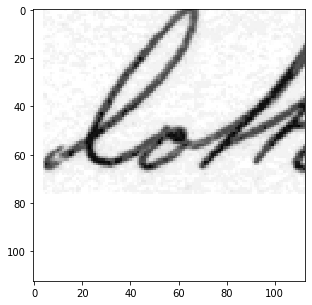

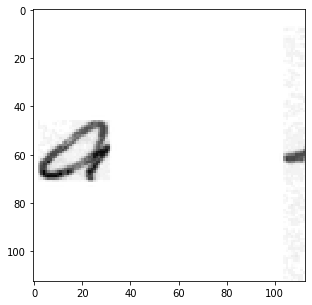

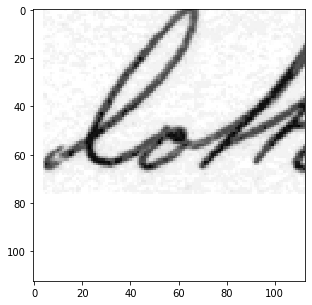

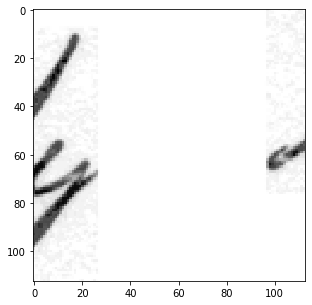

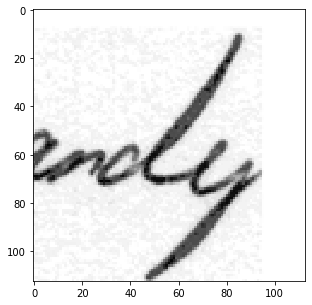

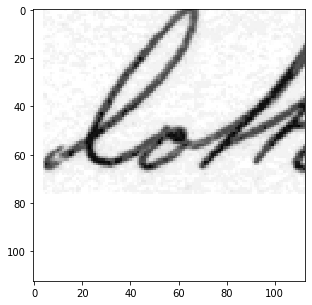

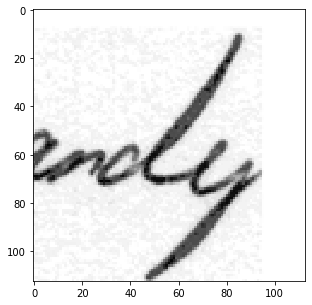

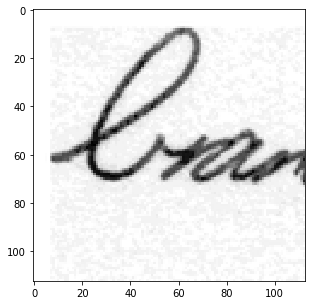

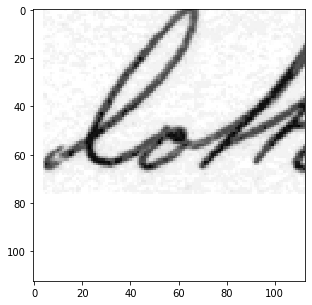

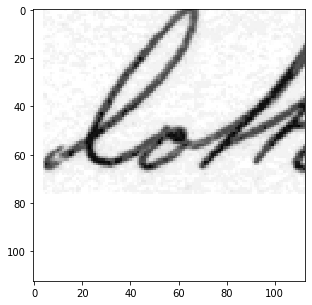

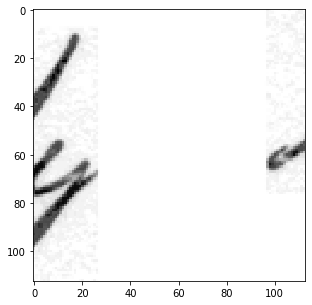

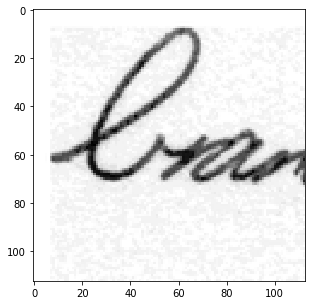

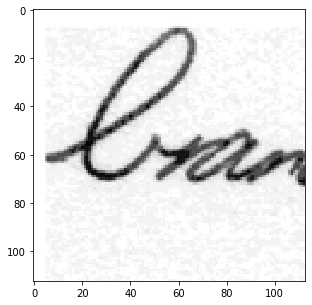

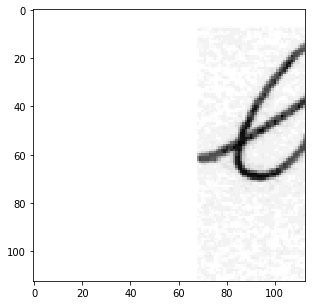

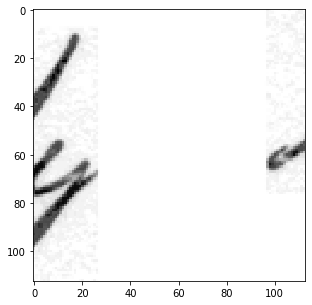

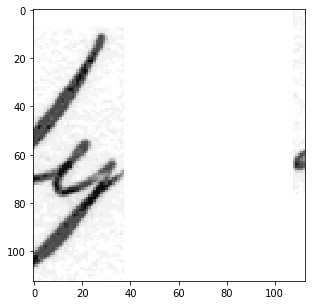

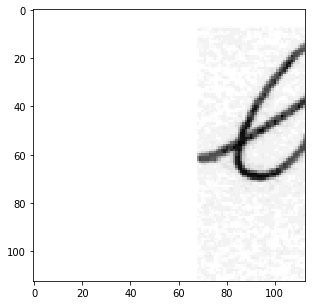

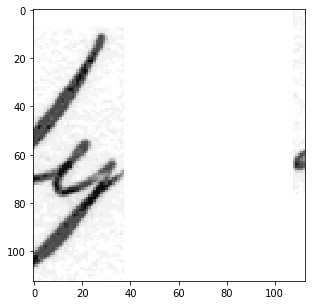

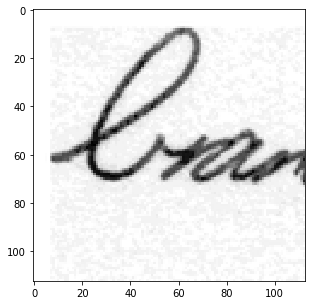

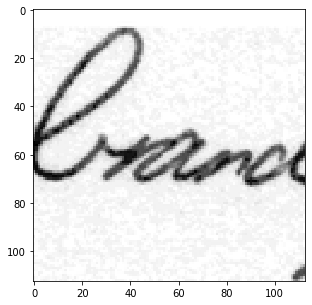

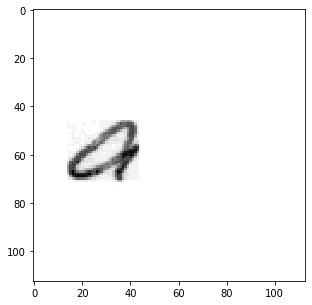

In [68]:
writer_number = predicted_writer[0]  # print all handwriting samples predicted to be the same writer as the first writer in the test set. you can change this around as needed
total_images =20
counter = 0
for i in range(len(predicted_writer)//10):
    if predicted_writer[i] == writer_number:
        image = X_test[i].squeeze()
        plt.figure(figsize=(5,5))
        plt.imshow(image, cmap ='gray')
        counter = counter + 1
        if counter > total_images:
            break